In [ ]:

# Notebook: SciKit Learn Support Vector Machine
# Author: Thomas Purk
# Date: 2025-03-29
# Reference: https://scikit-learn.org/stable/modules/svm.html
# Reference: https://www.ibm.com/think/topics/support-vector-machine
# Reference: https://archive.ics.uci.edu/dataset/94/spambase

# Support Vector Machines

>A support vector machine (SVM) is a supervised machine learning algorithm that classifies data by finding an optimal line or hyperplane that maximizes the distance between each class in an N-dimensional space.

[https://www.ibm.com/think/topics/support-vector-machine](https://www.ibm.com/think/topics/support-vector-machine)

**Dataset**

> Bohanec, M. (1988). Car Evaluation [Dataset]. UCI Machine Learning Repository. https://doi.org/10.24432/C5JP48.

In [ ]:
#Test
# Notebook Setup

# Data, Arrays, Numerical Compute
import numpy as np
import pandas as pd
import scipy

# Visualization & Display
from IPython.display import display, HTML
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

# Add for better Jupyter Notebook compatibility
%matplotlib inline

# Modeling
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Prevent Pandas and other warnings from displaying above outputcells, improve readability
import warnings
warnings.filterwarnings('ignore')
#warnings.filterwarnings(action='once') # See warnings one time

In [ ]:
# Notebook Functions

# Need way to test correlation hypoteses for categorical values
def cramers_v(index, columns):
    '''Calculate Cramér's V statistic for categorical-categorical association

    Parameters:
        index (pandas series): Values to group by in the rows.
        columns (pandas series or list): Values to group by in the columns.

    Returns:
        float: The result of the Cramér's V computation

    Interpreting the Output:
    - Chi-Square p-value < 0.05 → Suggests a significant relationship.
    - When n > 5,000, nearly all p-values will be close to 0, even for weak relationships.
        - Use Cramér’s V instead
    - Cramér’s V
        - closer to 1 → Stronger association;
        - closer to 0 means weak or no correlation.

    References:
        - https://en.wikipedia.org/wiki/Cram%C3%A9r%27s_V
        - https://medium.com/@manindersingh120996/understanding-categorical-correlations-with-chi-square-test-and-cramers-v-a54fe153b1d6
        - ChatGPT
        - Google AI Overview
        - SciPy documentation
    '''

    # Create the cross tabulations for the two columns
    cross_table = pd.crosstab(
        index=index,
        columns=columns
    )

    # Compute the independence test statistics
    chi2, p, dof, expected = scipy.stats.chi2_contingency(cross_table)
    # total observations
    n = cross_table.sum().sum()
    # compute Phi coefficient squared
    phi2 = chi2 / n
    # r -> number of rows, k -> number of columns
    r, k = cross_table.shape
    # Compute Cramér's V
    V = np.sqrt(phi2 / min(r - 1, k - 1))
    return V

def create_cramers_v_matrix(df):
    ''' Compute Cramér's V for all categorical variable pairs.

    Parametes:
        df (dataframe): A dataframe of categorical values.

    Returns:
        dataframe: A correlation matrix

    '''

    categorical_columns = df.columns
    # Track the values of each combo in a matrix
    cramers_v_matrix = pd.DataFrame(
        index=categorical_columns,
        columns=categorical_columns
    )

    # Iterate over the column combos
    for col1 in categorical_columns:
        for col2 in categorical_columns:
            if col1 == col2:
                cramers_v_matrix.loc[col1, col2] = 1.0  # Self-correlation
            else:
                cramers_v_matrix.loc[col1, col2] = cramers_v(df[col1], df[col2])

    # Convert to numeric for better visualization
    cramers_v_matrix = cramers_v_matrix.astype(float)

    return cramers_v_matrix

def print_all_value_counts(df):
    ''' Displays to output the value counts for each column in a Pandas DataFrame.

    Parameters:
        df (pd.DataFrame): The input DataFrame.

    '''

    html_str = '<table>'
    sub_tables = 0
    for col in df.columns:
        sub_tables += 1
        html_str += f'<th style="text-align:center"><td style="vertical-align:top">'
        html_str += df[col].value_counts().reset_index().to_html()
        html_str += '</td></th>'
        if(sub_tables > 4):
            # New row of sub-tables
            html_str += '</table><table>'
            sub_tables = 0

    html_str += '</table>'
    display(HTML(html_str))



In [ ]:
# Use the UC Irvine Machine Learning Repository's Python Package to load the data
#!pip install ucimlrepo
!pip list | grep ucimlrepo

ucimlrepo                          0.0.7


In [ ]:
# Load Data

from ucimlrepo import fetch_ucirepo

# fetch dataset
car_evaluation = fetch_ucirepo(id=19)

# data (as pandas dataframes)
X = car_evaluation.data.features
y = car_evaluation.data.targets

df = pd.concat([X,y], axis='columns')

# metadata
#print(car_evaluation.metadata)

# variable information
display(car_evaluation.variables[['name','description']])

,name,description
0,buying,buying price
1,maint,price of the maintenance
2,doors,number of doors
3,persons,capacity in terms of persons to carry
4,lug_boot,the size of luggage boot
5,safety,estimated safety of the car
6,class,"evaulation level (unacceptable, acceptable, go..."


In [ ]:

# Validate Data load

display(df.head())
print('')
display(df.head())

,buying,maint,doors,persons,lug_boot,safety,class
0,vhigh,vhigh,2,2,small,low,unacc
1,vhigh,vhigh,2,2,small,med,unacc
2,vhigh,vhigh,2,2,small,high,unacc
3,vhigh,vhigh,2,2,med,low,unacc
4,vhigh,vhigh,2,2,med,med,unacc


,buying,maint,doors,persons,lug_boot,safety,class
0,vhigh,vhigh,2,2,small,low,unacc
1,vhigh,vhigh,2,2,small,med,unacc
2,vhigh,vhigh,2,2,small,high,unacc
3,vhigh,vhigh,2,2,med,low,unacc
4,vhigh,vhigh,2,2,med,med,unacc


In [ ]:
# Structural Metadata
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1728 entries, 0 to 1727
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   buying    1728 non-null   object
 1   maint     1728 non-null   object
 2   doors     1728 non-null   object
 3   persons   1728 non-null   object
 4   lug_boot  1728 non-null   object
 5   safety    1728 non-null   object
 6   class     1728 non-null   object
dtypes: object(7)
memory usage: 94.6+ KB


In [ ]:
# Basic summary statistics
df.describe()

,buying,maint,doors,persons,lug_boot,safety,class
count,1728,1728,1728,1728,1728,1728,1728
unique,4,4,4,3,3,3,4
top,vhigh,vhigh,2,2,small,low,unacc
freq,432,432,432,576,576,576,1210


## Exploratory Data Analysis

Cramér's V Correlation Matrix:
             buying     maint     doors   persons  lug_boot    safety     class
buying    1.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.191063
maint     0.000000  1.000000  0.000000  0.000000  0.000000  0.000000  0.166052
doors     0.000000  0.000000  1.000000  0.000000  0.000000  0.000000  0.044758
persons   0.000000  0.000000  0.000000  1.000000  0.000000  0.000000  0.327791
lug_boot  0.000000  0.000000  0.000000  0.000000  1.000000  0.000000  0.124166
safety    0.000000  0.000000  0.000000  0.000000  0.000000  1.000000  0.372415
class     0.191063  0.166052  0.044758  0.327791  0.124166  0.372415  1.000000


Text(0.5, 1.0, "Cramér's V Correlation Matrix - Categorical Values")

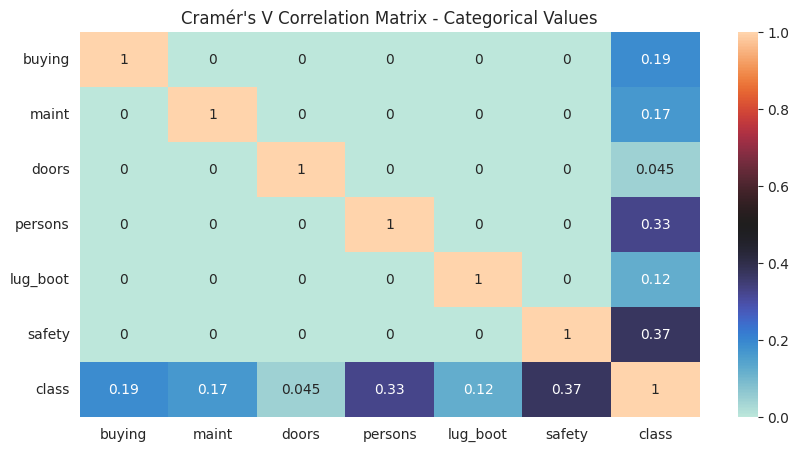

In [ ]:
# Which feature are most strongly correlated to class?

#list(plt.colormaps)

# Create a correlation matrix
cramers_v_matrix = create_cramers_v_matrix(df)
print("Cramér's V Correlation Matrix:\n", cramers_v_matrix)

plt.figure(figsize=(10,5))
sns.heatmap(
    data=cramers_v_matrix,
    annot=True,
    cmap='icefire'
)

# Add title
plt.title("Cramér's V Correlation Matrix - Categorical Values")

In [ ]:
# Explore different Combinations which may correlate to class

cv = cramers_v(
    index=df['class'],
    columns=[
        df['safety'], df['persons'], df['buying'], df['maint'] , df['lug_boot'], df['doors']
    ]
)
print(f'Safety-Persons-Buying-Maint-Boot-Doors: {cv}')


cv = cramers_v(
    index=df['class'],
    columns=[
        df['safety'], df['persons'], df['buying'], df['maint'] , df['lug_boot']
    ]
)
print(f'Safety-Persons-Buying-Maint-Boot: {cv}')


cv = cramers_v(
    index=df['class'],
    columns=[
        df['safety'], df['persons'], df['buying'], df['maint']
    ]
)
print(f'Safety-Persons-Buying-Maint: {cv}')


cv = cramers_v(
    index=df['class'],
    columns=[
        df['safety'], df['persons'], df['buying']
    ]
)
print(f'Safety-Persons-Buying: {cv}')


Safety-Persons-Buying-Maint-Boot-Doors: 1.0
Safety-Persons-Buying-Maint-Boot: 0.925442789028586
Safety-Persons-Buying-Maint: 0.7675879204018412
Safety-Persons-Buying: 0.5778943959031835


In [ ]:
# Unique counts for each feature
print_all_value_counts(df)

,buying,count
0,vhigh,432
1,high,432
2,med,432
3,low,432
,maint,count
0,vhigh,432
1,high,432
2,med,432
3,low,432
,doors,count


## Data Preprocessing

The data is already well formated. Just need to one-hot encode categorical features.

In [ ]:
X.columns

Index(['buying', 'maint', 'doors', 'persons', 'lug_boot', 'safety'], dtype='object')

In [ ]:
# One-hot encode the categorical data in the purpose column

X_encoded = pd.get_dummies(
    data=X,
    prefix={
        'buying':'buying',
        'maint': 'maint',
        'doors':'doors',
        'persons':'persons',
        'lug_boot':'lug_boot',
        'safety':'safety'
        },
    drop_first=True
)

# Validate
X_encoded.head()

,buying_low,buying_med,buying_vhigh,maint_low,maint_med,maint_vhigh,doors_3,doors_4,doors_5more,persons_4,persons_more,lug_boot_med,lug_boot_small,safety_low,safety_med
0,False,False,True,False,False,True,False,False,False,False,False,False,True,True,False
1,False,False,True,False,False,True,False,False,False,False,False,False,True,False,True
2,False,False,True,False,False,True,False,False,False,False,False,False,True,False,False
3,False,False,True,False,False,True,False,False,False,False,False,True,False,True,False
4,False,False,True,False,False,True,False,False,False,False,False,True,False,False,True


## Train a Model

In [ ]:
# Create training and testing datasets
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded,
    y,
    test_size=0.30,
    random_state=42
)

# Create and fit the model
svc_model = SVC(
    random_state=42,
    verbose=2
)
svc_model.fit(X_train,y_train)

svc_model

[LibSVM]

SVC(random_state=42, verbose=2)

In [ ]:
# Compute the classification predictions
predictions = svc_model.predict(X_test)
cr = classification_report(y_test,predictions)

print('Classification Report:')
print('')
print(cr)
print('')
print('precision: (true positives) / ((true positives) + (false positives))')
print('recall: (true positives) / ((true positives) + (false negatives))')
print('f1-score: 2 * ((precision * recall) / (precision + recall))')

Classification Report:

              precision    recall  f1-score   support

         acc       0.86      0.91      0.88       118
        good       0.68      0.79      0.73        19
       unacc       0.99      0.97      0.98       358
       vgood       0.86      0.75      0.80        24

    accuracy                           0.94       519
   macro avg       0.85      0.86      0.85       519
weighted avg       0.94      0.94      0.94       519


precision: (true positives) / ((true positives) + (false positives))
recall: (true positives) / ((true positives) + (false negatives))
f1-score: 2 * ((precision * recall) / (precision + recall))


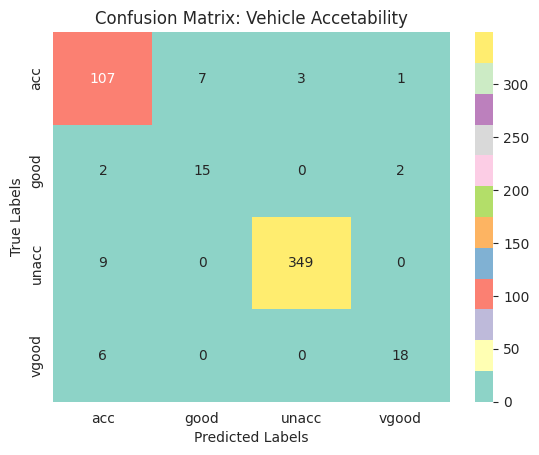

In [ ]:
# Explore a confusion matrix
cm = confusion_matrix(y_test, predictions)

# Unique class labels
classes = np.unique(y_test)

sns.heatmap(
    cm,
    annot=True,
    fmt='d', # string formating code
    xticklabels=classes,
    yticklabels=classes,
    cmap='Set3'
)

plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix: Vehicle Accetability')
plt.show()

## Hyperparameter Optimization with Grid Search

In [ ]:
# Create the optimization model
svc_opt = SVC(
    random_state=42,
    verbose=2
)

# Define the parameter grid
param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['rbf','linear'],
    'gamma': ['scale', 'auto'],
    'shrinking': [True, False],
    'class_weight': [None, 'balanced']
}

# Grid Search
grid_search = GridSearchCV(
    estimator=svc_opt,
    param_grid= param_grid,
    cv=5,
    n_jobs=4,
    verbose=2
)

grid_search.fit(X_train, y_train)

# Best parameters
print("Best Parameters:", grid_search.best_params_)

Fitting 5 folds for each of 48 candidates, totalling 240 fits
[LibSVM]Best Parameters: {'C': 10, 'class_weight': None, 'gamma': 'scale', 'kernel': 'rbf', 'shrinking': True}


In [ ]:
 # Evaluate on test set
svc_best = grid_search.best_estimator_
# accuracy = best_model.score(X_test, y_test)
# print("Test Accuracy:", accuracy)

# Check out the best model performance
svc_best_predictions = svc_best.predict(X_test)
svc_best_cr = classification_report(y_test,svc_best_predictions)

print('Classification Report:')
print('')
print(svc_best_cr)
print('')
print('precision: (true positives) / ((true positives) + (false positives))')
print('recall: (true positives) / ((true positives) + (false negatives))')
print('f1-score: 2 * ((precision * recall) / (precision + recall))')

Classification Report:

              precision    recall  f1-score   support

         acc       0.96      0.92      0.94       118
        good       0.67      0.84      0.74        19
       unacc       1.00      1.00      1.00       358
       vgood       0.87      0.83      0.85        24

    accuracy                           0.97       519
   macro avg       0.87      0.90      0.88       519
weighted avg       0.97      0.97      0.97       519


precision: (true positives) / ((true positives) + (false positives))
recall: (true positives) / ((true positives) + (false negatives))
f1-score: 2 * ((precision * recall) / (precision + recall))


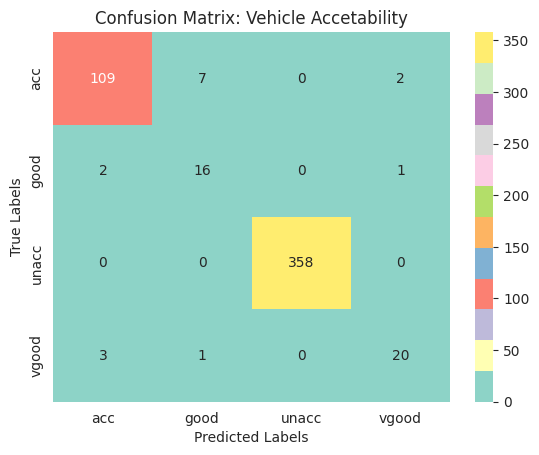

In [ ]:
# Explore a confusion matrix
svc_best_cm = confusion_matrix(y_test, svc_best_predictions)

# Unique class labels
classes = np.unique(y_test)

sns.heatmap(
    svc_best_cm,
    annot=True,
    fmt='d', # string formating code
    xticklabels=classes,
    yticklabels=classes,
    cmap='Set3'
)

plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix: Vehicle Accetability')
plt.show()

In [ ]:
# Observations
# - Better confusion matrix via optimization
# - Better classification report via optimization